## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
# ML imports
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torchvision import transforms

from avalanche.training import Naive

# from avalanche.models import SimpleMLP, SimpleCNN
from avalanche.benchmarks.classic import (
    RotatedMNIST,
    PermutedMNIST,
)  # ,PermutedOmniglot, RotatedOmniglot

import random
import numpy as np
from matplotlib import pyplot as plt

# Local imports
import models
import utils
from nets import SimpleCNN, SimpleMLP


In [2]:
# Config
device = utils.get_device()

dataset = RotatedMNIST

model = "mlp"
n_classes = 10
n_epochs = 1
n_hidden_layers = 2
latent_layer_number = -1
freeze_below_layer = "end_features.0"
n_experiences = 3
input_size = 784
hidden_size = 32
penultimate_layer_dim = hidden_size
replay_buffer_size = 6000 * n_experiences

SEED = 492

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

sanity_check_ablation_naive = {
    "latent_layer_number": -1,
    "freeze_below_layer": "end_features.0",
    "replay_buffer_size": 0,
}
sanity_check_ablation_replay = {
    "latent_layer_number": -1,
    "freeze_below_layer": "end_features.0",
    "replay_buffer_size": 1500,
}
sanity_check_ablation_latent_replay = {
    "latent_layer_number": 2,
    "freeze_below_layer": "end_features.0",
    "replay_buffer_size": 1500,
}



In [3]:
# Prepare for training & testing
l2 = 0.0005
momentum = 0.9
lr = 0.001

model_2 = SimpleMLP(
    input_size=input_size,
    hidden_layers=n_hidden_layers,
    num_classes=n_classes,
    hidden_size=hidden_size,
)

naive_strategy = Naive(
    model=model_2,
    criterion=CrossEntropyLoss(),
    optimizer=SGD(model_2.parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=32,
    train_epochs=n_epochs,
    eval_mb_size=32,
    device=device,
)



In [4]:
if model == "mlp":
    model = SimpleMLP(
        input_size=input_size,
        hidden_layers=n_hidden_layers,
        num_classes=n_classes,
        hidden_size=hidden_size,
    )
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))]
    )

elif model == "cnn":
    model = SimpleCNN(num_classes=n_classes)
    penultimate_layer_dim = 64
    transform = transforms.Compose([transforms.ToTensor()])

else:
    # CL Benchmark Creation
    # Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
    transform = transforms.Compose(
        [
            # transforms.Lambda(lambda x: x.convert('RGB')),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        ]
    )



In [5]:
# Prepare for training & testing

# Continual learning strategy
# cl_strategy = models.LatentReplay(criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, device=device)

cl_strategy = models.AR1(
    model=model,
    penultimate_layer_dim=penultimate_layer_dim,
    criterion=CrossEntropyLoss(),
    rm_sz=replay_buffer_size,
    train_mb_size=32,
    train_epochs=n_epochs,
    eval_mb_size=32,
    latent_layer_num=latent_layer_number,
    freeze_below_layer=freeze_below_layer,
    device=device,
)



FrozenNet(
  (lat_features): Sequential()
  (end_features): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=32, out_features=10, bias=False)
)


c:\Users\jacob\Documents\GitHub\generative-latent-replay\models\ar1.py:115: UserWarning: The AR1 strategy implementation is in an alpha stage and is not perfectly aligned with the paper implementation. Please use at your own risk!
  warnings.warn(


In [6]:
for model, results in [
    (cl_strategy, (results_ar1 := [])),
    # (naive_strategy, (results_naive := [])),
]:
    experiences = dataset(
        n_experiences=n_experiences,
        train_transform=transform,
        eval_transform=transform,
        seed=SEED,
    )
    train_stream = experiences.train_stream
    test_stream = experiences.test_stream

    for train_exp in train_stream:
        model.train(train_exp)
        results.append(model.eval(train_stream))


-- >> Start of training phase << --
100%|██████████| 1875/1875 [00:45<00:00, 41.61it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.8634
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.3327
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from train stream --
100%|██████████| 1875/1875 [00:13<00:00, 135.67it/s]
> Eval on experience 0 (Task 0) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task000/Exp000 = 0.9554
	Top1_Acc_Exp/eval_phase/train_stream/Task000/Exp000 = 0.7843
-- Starting eval on experience 1 (Task 1) from train stream --
100%|██████████| 1875/1875 [00:13<00:00, 135.71it/s]
> Eval on experience 1 (Task 1) from train stream ended.
	Loss_Exp/eval_phase/train_stream/Task001/Exp001 = 2.4820
	Top1_Acc_Exp/eval_phase/train_stream/Task001/Exp001 = 0.1190
-- Starting eval on experience 2 (Task 2) from train stream --
100%|██████████| 1875/1875 [00:13<00:00, 134.38it/s]
> Eval on experie

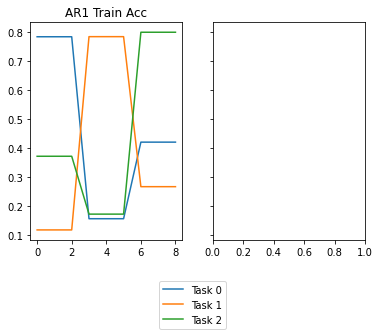

In [7]:
# JA: Next step - replace internal model.
# - model def ✅
# - frozen layer name ✅
# - batch renorm stuff...?

# JA: 2nd step
# - make GMM
# - add GMM to model sampler

import importlib
import utils  # import the module here, so that it can be reloaded.

importlib.reload(utils)

fig, axes = plt.subplots(1, 2, sharey=True)
repeat_vals = 3

try:
    results_ar1_clean = utils.plot_results(
        results_ar1, "AR1", axes[0], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass
try:
    results_naive_clean = utils.plot_results(
        results_naive, "Naive", axes[1], n_experiences, "acc", repeat_vals=repeat_vals
    )
except:
    pass
# results_ar1_clean = utils.plot_results(results_ar1, 'AR1', axes[1][0], 'loss')
# results_naive_clean = utils.plot_results(results_naive, 'Naive', axes[1][1], 'loss')

# print(results_ar1_clean["train"]['acc'])
# print(results_naive_clean["train"]['acc'])

utils.plot_single_legend(fig)
